In [10]:
%%time
import json
import os
import csv
import urllib
from io import BytesIO
from pil import Image

from socket import timeout

# # from google.colab import files

!pip3 install -q torch torchvision
# !pip3 install -q Pillow==4.0.0
!pip3 install -q Pillow==8.0.1

Wall time: 3.55 s


In [3]:
train_folder = "train_kaggle/"
test_folder = "test_kaggle/"

In [13]:
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the test folder 1150


In [14]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

Wall time: 449 ms


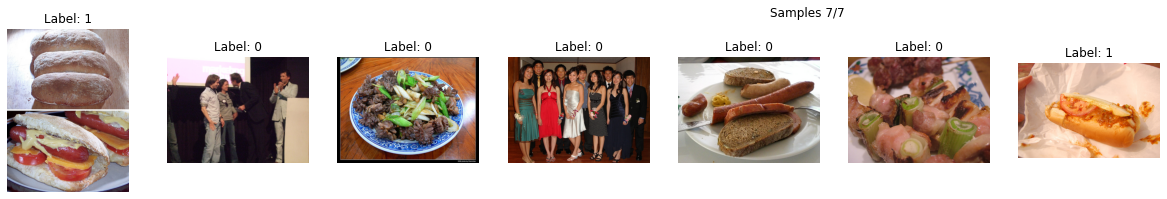

In [20]:
%%time
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.root = folder
        self.image_files = os.listdir(self.root)
        
        # TODO: Your code here!
        # (samples, file_name, labels[])
        
    def __len__(self):
        return len(self.image_files)
        
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        image_name = os.path.join(self.root, self.image_files[index])
        image = Image.open(image_name)
        if self.transform: 
            image = self.transform(image)
            
        if ('frankfurter' in image_name 
            or 'chili-dog' in image_name 
            or 'hotdog' in image_name):
            y = 1
        else:
            y = 0
            
        img_id = image_name
            
        return image, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

In [21]:
%%time
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

TypeError: img should be PIL Image. Got <class 'pil.JpegImagePlugin.JpegImageFile'>

<Figure size 2160x216 with 0 Axes>

In [ ]:
%%time
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [ ]:
%%time
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
%%time
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct = 0
    total = 0
    
    for x, y in loader:
        _x = x.to(device)
        _y = y.to(device)
        
        prediction = model(_x)
        
        indices =  torch.argmax(prediction, dim=1)
        _indices = indices.to(device)
        
        correct += torch.sum(indices == _y)
        
        total += _y.size(0) 
        
    return float(correct) / total

In [ ]:
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)
print(indices)
visualize_samples(dataset, indices, "Samples random!")
# samples = list((lambda x: for idx in len(indices): orig_dataset[idx], orig_dataset))
# print(len(samples))
samples = list(map(lambda x: orig_dataset[x], indices))
print(len(samples))
visualize_samples(samples, [0,1,2,3,4,5,6,7,8,9], "Samples subsample")

In [ ]:
%%time

import torch.nn as nn
import torch.optim as optim

# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# # TODO: Run this model on 10 random images of your dataset and visualize what it predicts
# train_indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)
# # samples = list(map(lambda x: orig_dataset[x], train_indices))
# indices_without_train = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)
# val_indices = np.random.choice(indices_without_train, 10, replace=False)

# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
# val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

# # def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs)
# loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
# loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 8)

def visualize_model(dataset, indices, classes, model, title=None, count=10):
    plt.figure(figsize=(count * 3, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))  
        
    model.eval()
    for i, index in enumerate(display_indices):
        x, _, _ = dataset[index]
        _, pred = torch.max(model(x.unsqueeze(0)), 1)
        plt.subplot(1, count, i + 1)
        plt.title("Class: %s" % classes[int(pred)])
        plt.imshow(x.numpy().transpose((1, 2, 0)).astype(np.uint8))
        plt.grid(False)
        plt.axis('off')


indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)
classes = load_imagenet_classes()
visualize_model(train_dataset, indices, classes, model)

In [ ]:
%%time
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

parameters = model.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)